# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque 

from agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)

In [6]:
def maddpg(n_episodes=10000, max_t=10000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    beta = 1.0  # factor the random noise gets multiplied with
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  # get the current states
        e_scores = np.zeros(2)  # the scores of an episode for both tennis agents
        agent.reset()
        for t in range(max_t):
            if i_episode < 100:
                actions = np.random.randn(2, 2)  # use random actions for the first 100 episodes
            else:
                actions = agent.act(states)  # let the agent select actions
            actions_p2 = np.flip(actions, 0)                    # The actions of the other player
            env_info = env.step(actions)[brain_name]            # execute the selected actions and save the new information about the environment
            rewards = env_info.rewards                          # get the rewards
            next_states = env_info.vector_observations          # get the resulting states
            next_states_p2 = np.flip(next_states, 0)            # get the resulting states for the other player
            dones = env_info.local_done                         # check whether episodes have finished
            agent.step(states, actions, actions_p2, rewards, next_states, next_states_p2, dones)  # pass the information to the agent
            states = next_states
            e_scores += rewards
            if np.any(dones):
                break
        max_score = np.max(e_scores)  # the max score of the agents
        scores_deque.append(max_score)
        scores.append(max_score)
        beta = max(0.999 * beta, 0.01)  # reduce the noise a bit while training
        print('\rEpisode {:d}\tmax score: {:.2f}\taverage maximum score over the last 10 episodes: {:.2f}'.format(i_episode, scores_deque[-1], np.mean(list(scores_deque)[-10:])), end="")

        if i_episode > 100 and np.mean(scores_deque) > 0.5:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = maddpg()
env.close()  # close the environment as it is no longer needed

Episode 100	Average Score: 0.02rage maximum score over the last 10 episodes: 0.00
Episode 200	Average Score: 0.00rage maximum score over the last 10 episodes: 0.00
Episode 300	Average Score: 0.00rage maximum score over the last 10 episodes: 0.00
Episode 400	Average Score: 0.00rage maximum score over the last 10 episodes: 0.00
Episode 500	Average Score: 0.00rage maximum score over the last 10 episodes: 0.01
Episode 600	Average Score: 0.00rage maximum score over the last 10 episodes: 0.01
Episode 700	Average Score: 0.00rage maximum score over the last 10 episodes: 0.00
Episode 800	Average Score: 0.00rage maximum score over the last 10 episodes: 0.00
Episode 900	Average Score: 0.00rage maximum score over the last 10 episodes: 0.00
Episode 1000	Average Score: 0.00rage maximum score over the last 10 episodes: 0.00
Episode 1100	Average Score: 0.00rage maximum score over the last 10 episodes: 0.00
Episode 1200	Average Score: 0.00rage maximum score over the last 10 episodes: 0.00
Episode 1300	

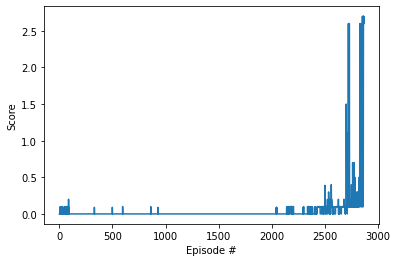

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()